In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [6]:

# -------------------------------
# Load scenario data
# -------------------------------

pts = np.loadtxt("scenario_pts.txt")
wgts = np.loadtxt("scenario_prb_wgts_new.txt")

print(f"pts shape: {pts.shape}")
print(f"wgts shape: {wgts.shape}")

wgts = wgts / np.sum(wgts)

N, D = pts.shape
k = 20  # number of clusters

# -------------------------------
# Weighted K-Means
# -------------------------------
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pts, sample_weight=wgts)
kmeans_labels = kmeans.predict(pts)
kmeans_centroids = kmeans.cluster_centers_
kmeans_cluster_wgts = np.array([wgts[kmeans_labels == i].sum() for i in range(k)])

kmeans_cost = np.sum(
    wgts * np.min(((pts[:, None, :] - kmeans_centroids[None, :, :])**2).sum(axis=2), axis=1)
)

# Save K-Means representatives
df_kmeans = pd.DataFrame(kmeans_centroids, columns=[f"KL_mode_{i+1}" for i in range(D)])
df_kmeans["Cluster_Weight"] = kmeans_cluster_wgts
df_kmeans.to_csv("KMeans_representative_scenarios.csv", index=False)

# -------------------------------
# Weighted K-Medoids (PAM)
# -------------------------------
def pairwise_dist(X, Y):
    """Euclidean distance matrix between X and Y."""
    X2 = np.sum(X**2, axis=1, keepdims=True)
    Y2 = np.sum(Y**2, axis=1, keepdims=True).T
    d2 = X2 + Y2 - 2 * X @ Y.T
    d2 = np.maximum(d2, 0.0)
    return np.sqrt(d2)

def weighted_kmedoids(pts, wgts, k=20, max_iter=100, seed=42):
    rng = np.random.default_rng(seed)
    N = pts.shape[0]

    # Init medoids with weighted probability
    medoid_indices = [rng.choice(N, p=wgts)]
    for _ in range(1, k):
        current = pts[medoid_indices]
        d = pairwise_dist(pts, current)
        nearest_d = d.min(axis=1)
        probs = wgts * (nearest_d / (nearest_d.sum() + 1e-12))
        probs = probs / probs.sum()
        medoid_indices.append(rng.choice(N, p=probs))
    medoid_indices = np.array(medoid_indices, dtype=int)

    # Iterative refinement
    for _ in range(max_iter):
        medoids = pts[medoid_indices]
        D_to_medoids = pairwise_dist(pts, medoids)
        labels = D_to_medoids.argmin(axis=1)
        changed = False
        for m_idx in range(k):
            members = np.where(labels == m_idx)[0]
            if members.size == 0:
                continue
            subD = pairwise_dist(pts[members], pts[members])
            w_sub = wgts[members]
            candidate_costs = subD.T @ w_sub
            best_local_idx = members[np.argmin(candidate_costs)]
            if best_local_idx != medoid_indices[m_idx]:
                medoid_indices[m_idx] = best_local_idx
                changed = True
        if not changed:
            break

    medoids = pts[medoid_indices]
    D_to_medoids = pairwise_dist(pts, medoids)
    labels = D_to_medoids.argmin(axis=1)
    cluster_wgts = np.array([wgts[labels == i].sum() for i in range(k)])
    cost = np.sum(wgts * np.min(D_to_medoids, axis=1))
    return medoid_indices, medoids, labels, cluster_wgts, cost

medoid_indices, medoids, medoid_labels, medoid_cluster_wgts, medoid_cost = weighted_kmedoids(pts, wgts, k=k)

# Save K-Medoids representatives
df_kmedoids = pd.DataFrame(medoids, columns=[f"KL_mode_{i+1}" for i in range(D)])
df_kmedoids["Cluster_Weight"] = medoid_cluster_wgts
df_kmedoids["Medoid_Index"] = medoid_indices
df_kmedoids.to_csv("KMedoids_representative_scenarios.csv", index=False)


pts shape: (100, 20)
wgts shape: (100,)


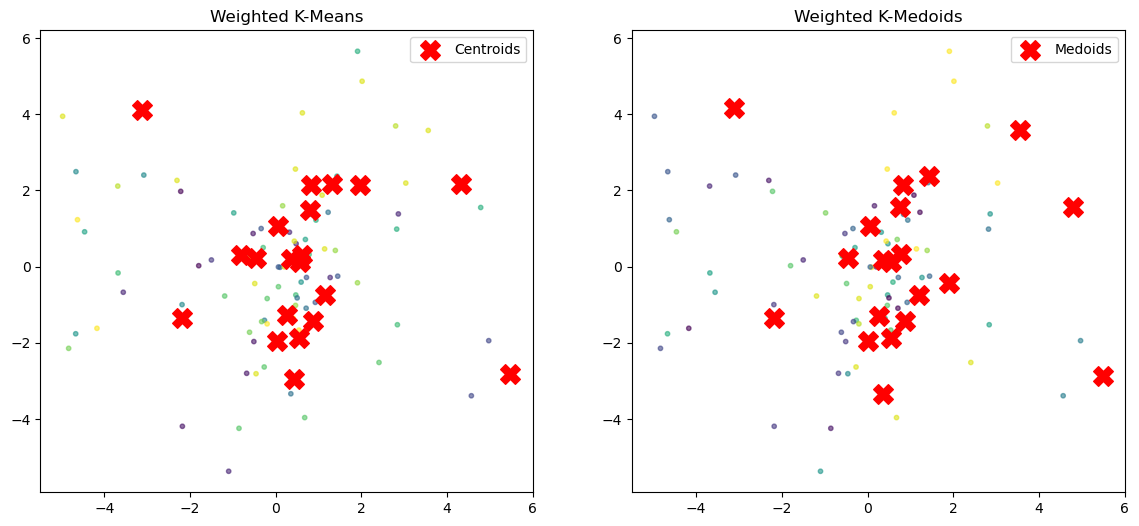

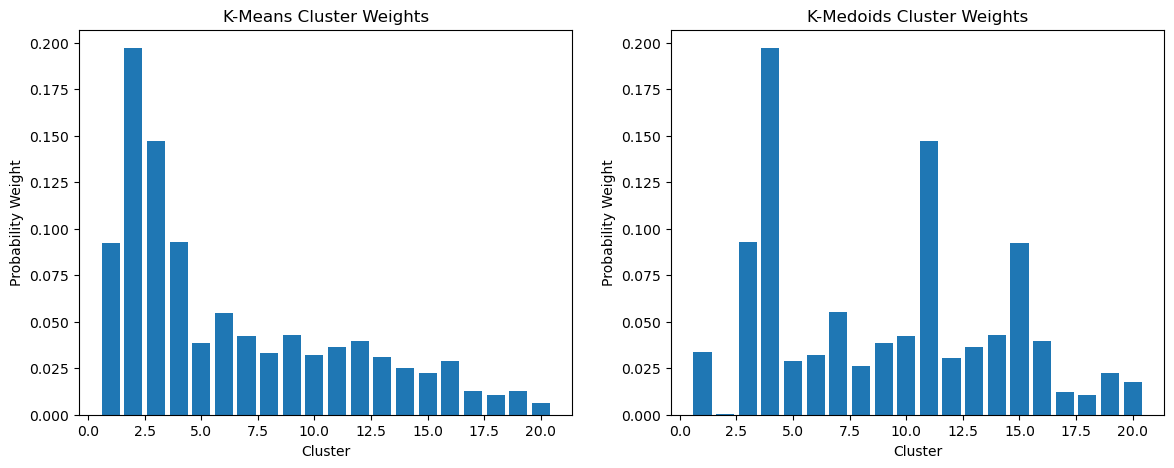

      Method      Cost  Min Cluster Weight  Max Cluster Weight  \
0    K-Means  2.144659            0.006123            0.197017   
1  K-Medoids  0.314315            0.000640            0.197017   

   Avg Cluster Weight  
0                0.05  
1                0.05  


In [7]:

# -------------------------------
# PCA visualization
# -------------------------------
pca = PCA(n_components=2)
pts_2d = pca.fit_transform(pts)
kmeans_2d = pca.transform(kmeans_centroids)
medoids_2d = pca.transform(medoids)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# K-Means scatter
axes[0].scatter(pts_2d[:,0], pts_2d[:,1], c=kmeans_labels, s=10, alpha=0.6)
axes[0].scatter(kmeans_2d[:,0], kmeans_2d[:,1], marker="X", s=200, c="red", label="Centroids")
axes[0].set_title("Weighted K-Means")
axes[0].legend()

# K-Medoids scatter
axes[1].scatter(pts_2d[:,0], pts_2d[:,1], c=medoid_labels, s=10, alpha=0.6)
axes[1].scatter(medoids_2d[:,0], medoids_2d[:,1], marker="X", s=200, c="red", label="Medoids")
axes[1].set_title("Weighted K-Medoids")
axes[1].legend()

plt.show()

# -------------------------------
# Cluster weight distributions
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].bar(np.arange(1, k+1), kmeans_cluster_wgts)
axes[0].set_title("K-Means Cluster Weights")
axes[0].set_xlabel("Cluster"); axes[0].set_ylabel("Probability Weight")

axes[1].bar(np.arange(1, k+1), medoid_cluster_wgts)
axes[1].set_title("K-Medoids Cluster Weights")
axes[1].set_xlabel("Cluster"); axes[1].set_ylabel("Probability Weight")

plt.show()

# -------------------------------
# Numerical summary
# -------------------------------
summary = pd.DataFrame({
    "Method": ["K-Means", "K-Medoids"],
    "Cost": [kmeans_cost, medoid_cost],
    "Min Cluster Weight": [kmeans_cluster_wgts.min(), medoid_cluster_wgts.min()],
    "Max Cluster Weight": [kmeans_cluster_wgts.max(), medoid_cluster_wgts.max()],
    "Avg Cluster Weight": [kmeans_cluster_wgts.mean(), medoid_cluster_wgts.mean()]
})
print(summary)


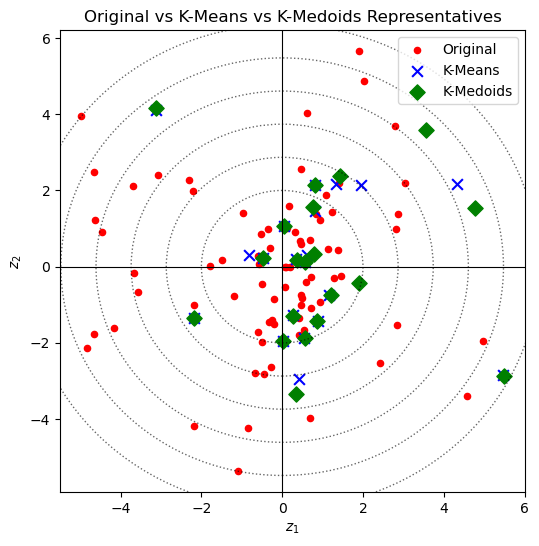

In [9]:
# -------------------------------
# PCA 2D projection
# -------------------------------
pca2 = PCA(n_components=2)
pts_2d_full = pca2.fit_transform(pts)
kmeans_reduced_2d = pca2.transform(kmeans_centroids)
kmedoids_reduced_2d = pca2.transform(medoids)

# -------------------------------
# Combined comparison plot
# -------------------------------
fig, ax = plt.subplots(figsize=(6,6))

# Original scenarios
ax.scatter(pts_2d_full[:,0], pts_2d_full[:,1], c="red", s=20, label="Original")

# K-Means representatives
ax.scatter(kmeans_reduced_2d[:,0], kmeans_reduced_2d[:,1],
           c="blue", s=60, marker="x", label="K-Means")

# K-Medoids representatives
ax.scatter(kmedoids_reduced_2d[:,0], kmedoids_reduced_2d[:,1],
           c="green", s=60, marker="D", label="K-Medoids")

# Axes
ax.axhline(0, color="black", linewidth=0.8)
ax.axvline(0, color="black", linewidth=0.8)

# Concentric circles
max_radius = np.max(np.linalg.norm(pts_2d_full, axis=1))
for r in np.linspace(2, max_radius, 6):
    circ = plt.Circle((0,0), r, color="black", fill=False, linestyle="dotted", alpha=0.6)
    ax.add_patch(circ)

ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
ax.set_title("Original vs K-Means vs K-Medoids Representatives")
ax.legend()
plt.show()


#### Weighted K-Medoids

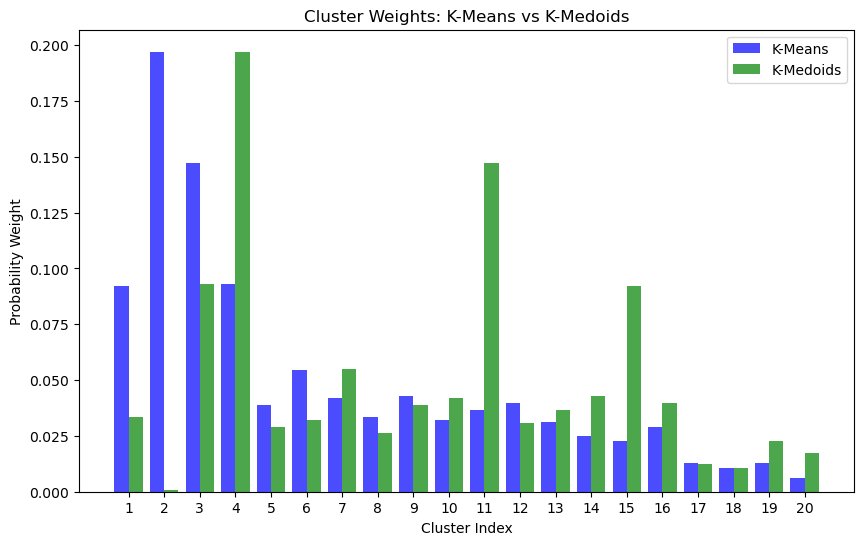

In [10]:
# -------------------------------
# Side-by-side bar chart of cluster weights
# -------------------------------
fig, ax = plt.subplots(figsize=(10,6))

bar_width = 0.4
indices = np.arange(1, k+1)

# K-Means bars (blue)
ax.bar(indices - bar_width/2, kmeans_cluster_wgts, 
       width=bar_width, color="blue", alpha=0.7, label="K-Means")

# K-Medoids bars (green)
ax.bar(indices + bar_width/2, medoid_cluster_wgts, 
       width=bar_width, color="green", alpha=0.7, label="K-Medoids")

ax.set_xlabel("Cluster Index")
ax.set_ylabel("Probability Weight")
ax.set_title("Cluster Weights: K-Means vs K-Medoids")
ax.set_xticks(indices)
ax.legend()

plt.show()


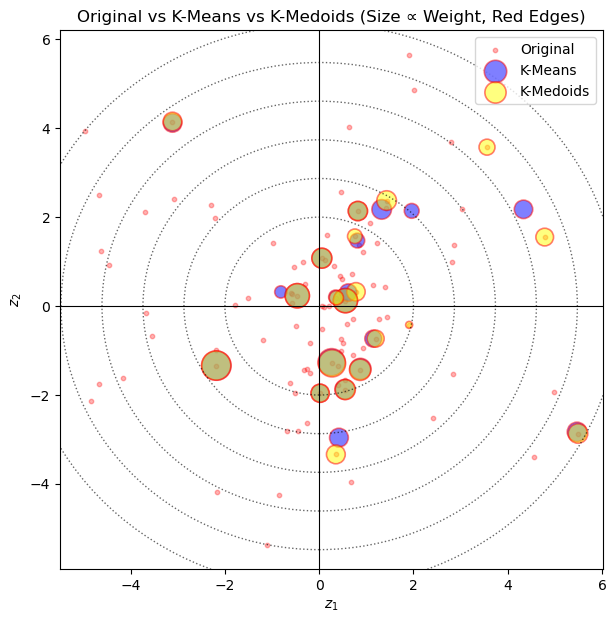

In [14]:
# -------------------------------
# Combined weighted scatter with edge colors
# -------------------------------
fig, ax = plt.subplots(figsize=(7,7))

# Original scenarios (background, small red dots)
ax.scatter(pts_2d_full[:,0], pts_2d_full[:,1], 
           c="red", s=10, alpha=0.3, label="Original")

# Scale sizes so that radius ∝ sqrt(weight)
scale_factor = 1000  # adjust this for visualization
kmeans_sizes = scale_factor * np.sqrt(kmeans_cluster_wgts)
kmedoids_sizes = scale_factor * np.sqrt(medoid_cluster_wgts)

# K-Means representatives (blue circles, size ∝ weight, red edges)
ax.scatter(kmeans_reduced_2d[:,0], kmeans_reduced_2d[:,1],
           s=kmeans_sizes, c="blue", marker="o", edgecolors="red", linewidths=1.2,
           alpha=0.5, label="K-Means")

# K-Medoids representatives (green circles, size ∝ weight, red edges)
ax.scatter(kmedoids_reduced_2d[:,0], kmedoids_reduced_2d[:,1],
           s=kmedoids_sizes, c="yellow", marker="o", edgecolors="red", linewidths=1.2,
           alpha=0.5, label="K-Medoids")

# Axes
ax.axhline(0, color="black", linewidth=0.8)
ax.axvline(0, color="black", linewidth=0.8)

# Concentric circles (for reference)
max_radius = np.max(np.linalg.norm(pts_2d_full, axis=1))
for r in np.linspace(2, max_radius, 6):
    circ = plt.Circle((0,0), r, color="black", fill=False, linestyle="dotted", alpha=0.6)
    ax.add_patch(circ)

ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
ax.set_title("Original vs K-Means vs K-Medoids (Size ∝ Weight, Red Edges)")
ax.legend()
plt.show()
